Stroke Prediction Model
Dataset shape: (5109, 10)
Target distribution:
stroke
0    4860
1     249
Name: count, dtype: int64
Class imbalance ratio: 19.52:1

Cross-Validation Results:
------------------------------
ROC_AUC: 0.837 (±0.020)
PRECISION: 0.130 (±0.011)
RECALL: 0.792 (±0.061)
F1: 0.223 (±0.018)


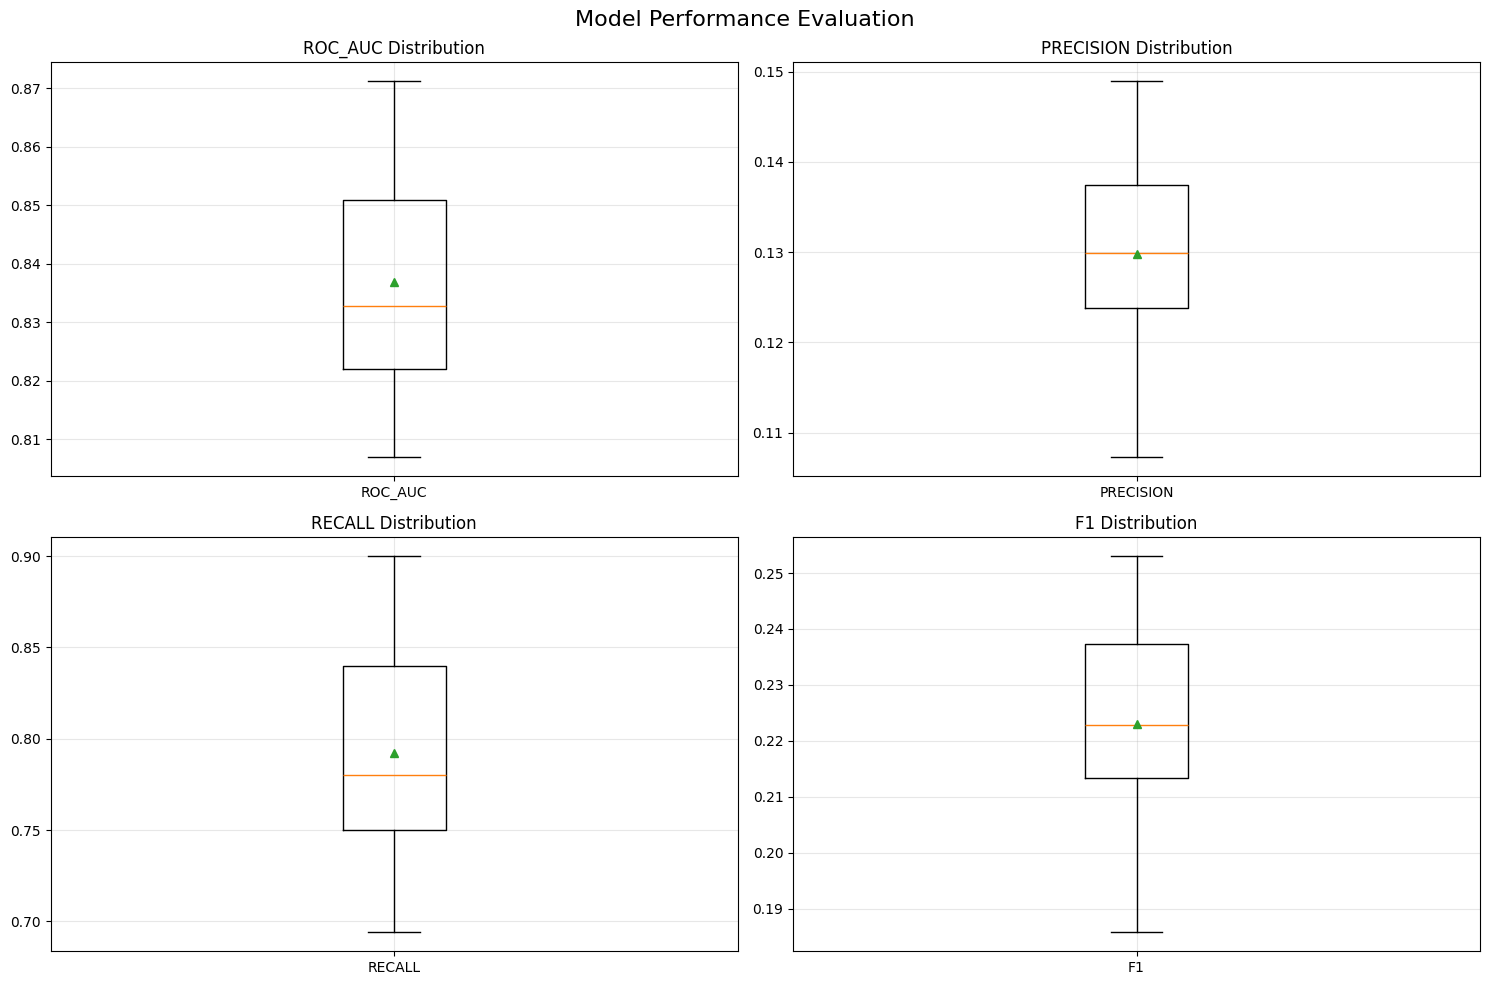


Detailed Evaluation:
------------------------------
DETAILED EVALUATION RESULTS
Test Set Size: 1022 samples
AUC-ROC Score: 0.843

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.82      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.72      0.80      1022



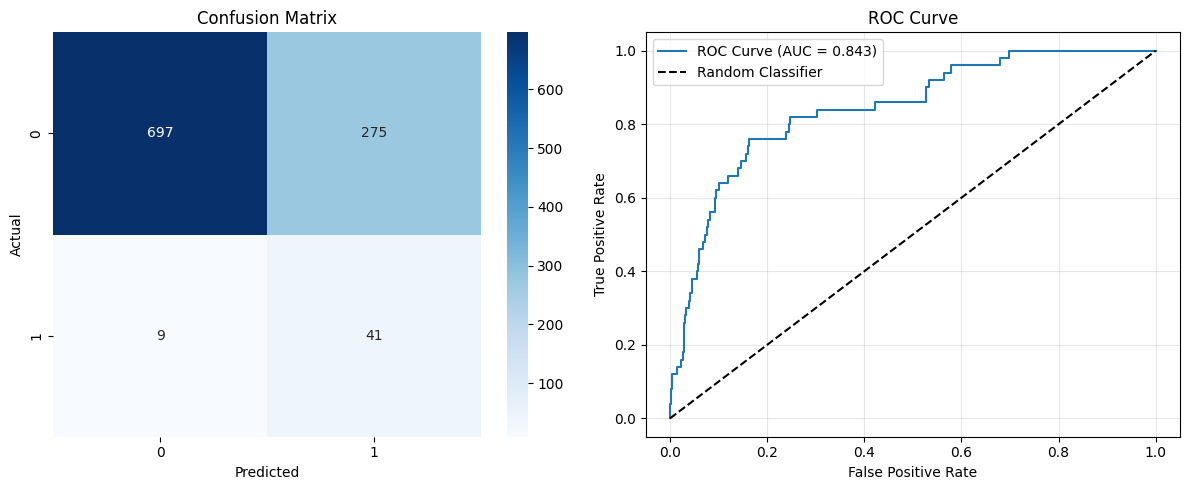


Training on full dataset...
Model saved to improved_stroke_model.joblib

Model training and evaluation completed!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

class StrokePredictionModel:
    """
    A comprehensive stroke prediction model,
    evaluation, and visualization capabilities.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.pipeline = None
        self.feature_names = None
        self.categorical_features = None
        self.numerical_features = None

    def load_and_preprocess_data(self, filepath='/content/stroke-data.csv'):
        """
        Load and preprocess the stroke dataset with improved data handling.
        """
        try:
            df = pd.read_csv(filepath)
        except FileNotFoundError:
            # If file not found, create sample data from the provided data
            print("Creating sample dataset...")
            df = self._create_sample_data()

        # Remove ID column if present
        if 'id' in df.columns:
            df = df.drop('id', axis=1)

        # Handle 'Other' gender category (very small sample)
        if 'gender' in df.columns:
            df = df[df['gender'] != 'Other']  # Remove 'Other' gender (only 1 sample)

        # Define feature categories with improved categorization
        self.categorical_features = [
            'gender', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'smoking_status'
        ]
        self.numerical_features = ['age', 'avg_glucose_level', 'bmi']

        # Ensure all categorical features exist in the dataset
        self.categorical_features = [col for col in self.categorical_features if col in df.columns]
        self.numerical_features = [col for col in self.numerical_features if col in df.columns]

        # Separate features and target
        y = df['stroke']
        X = df.drop('stroke', axis=1)

        print(f"Dataset shape: {X.shape}")
        print(f"Target distribution:\n{y.value_counts()}")
        print(f"Class imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

        return X, y

    def _create_sample_data(self):
        """Create a sample dataset for demonstration purposes."""
        np.random.seed(self.random_state)
        n_samples = 1000

        data = {
            'gender': np.random.choice(['Male', 'Female'], n_samples),
            'age': np.random.normal(45, 20, n_samples).clip(0, 100),
            'hypertension': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
            'heart_disease': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
            'ever_married': np.random.choice(['Yes', 'No'], n_samples, p=[0.7, 0.3]),
            'work_type': np.random.choice(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
                                        n_samples, p=[0.5, 0.2, 0.15, 0.1, 0.05]),
            'Residence_type': np.random.choice(['Urban', 'Rural'], n_samples),
            'avg_glucose_level': np.random.normal(100, 30, n_samples).clip(50, 300),
            'bmi': np.random.normal(25, 5, n_samples).clip(15, 50),
            'smoking_status': np.random.choice(['never smoked', 'formerly smoked', 'smokes', 'Unknown'],
                                             n_samples, p=[0.4, 0.3, 0.2, 0.1]),
            'stroke': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
        }

        return pd.DataFrame(data)

    def create_preprocessing_pipeline(self):
        """
        Create an improved preprocessing pipeline with better handling of mixed data types.
        """
        # Numerical preprocessing: imputation + scaling
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # Categorical preprocessing: imputation + encoding
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Combine transformers
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='drop'  # Drop any remaining columns
        )

        return preprocessor

    def build_model(self):
        """
        Build the complete model pipeline with improved configuration.
        """
        preprocessor = self.create_preprocessing_pipeline()

        # Create the full pipeline
        self.pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampling', SMOTE(random_state=self.random_state, k_neighbors=3)),  # Reduced k_neighbors for small datasets
            ('classifier', LinearDiscriminantAnalysis(solver='svd'))  # SVD solver is more stable
        ])

        return self.pipeline

    def evaluate_model(self, X, y, scoring_metrics=None):
        """
        Comprehensive model evaluation with multiple metrics.
        """
        if scoring_metrics is None:
            scoring_metrics = ['roc_auc', 'precision', 'recall', 'f1']

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=self.random_state)

        results = {}
        for metric in scoring_metrics:
            scores = cross_val_score(self.pipeline, X, y, scoring=metric, cv=cv, n_jobs=-1)
            results[metric] = {
                'mean': np.mean(scores),
                'std': np.std(scores),
                'scores': scores
            }
            print(f'{metric.upper()}: {np.mean(scores):.3f} (±{np.std(scores):.3f})')

        return results

    def plot_evaluation_results(self, results):
        """
        Create comprehensive visualization of model performance.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Model Performance Evaluation', fontsize=16)

        # Box plots for each metric
        metrics = list(results.keys())
        for i, metric in enumerate(metrics):
            row, col = i // 2, i % 2
            if i < 4:  # Only plot first 4 metrics
                axes[row, col].boxplot([results[metric]['scores']],
                                     labels=[metric.upper()], showmeans=True)
                axes[row, col].set_title(f'{metric.upper()} Distribution')
                axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def detailed_evaluation(self, X, y, test_size=0.2):
        """
        Perform detailed evaluation with train-test split and comprehensive metrics.
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )

        # Fit the model
        self.pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = self.pipeline.predict(X_test)
        y_pred_proba = self.pipeline.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print("=" * 50)
        print("DETAILED EVALUATION RESULTS")
        print("=" * 50)
        print(f"Test Set Size: {len(X_test)} samples")
        print(f"AUC-ROC Score: {auc_score:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix and ROC curve
        self._plot_detailed_results(y_test, y_pred, y_pred_proba)

        return {
            'auc_score': auc_score,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

    def _plot_detailed_results(self, y_test, y_pred, y_pred_proba):
        """Plot confusion matrix and ROC curve."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath='stroke_prediction_model.joblib'):
        """Save the trained model with metadata."""
        if self.pipeline is None:
            raise ValueError("Model must be trained before saving")

        model_data = {
            'pipeline': self.pipeline,
            'categorical_features': self.categorical_features,
            'numerical_features': self.numerical_features,
            'random_state': self.random_state
        }

        dump(model_data, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='stroke_prediction_model.joblib'):
        """Load a previously trained model."""
        model_data = load(filepath)
        self.pipeline = model_data['pipeline']
        self.categorical_features = model_data['categorical_features']
        self.numerical_features = model_data['numerical_features']
        self.random_state = model_data['random_state']
        print(f"Model loaded from {filepath}")

    def predict(self, X):
        """Make predictions on new data."""
        if self.pipeline is None:
            raise ValueError("Model must be trained or loaded before making predictions")
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        """Get prediction probabilities."""
        if self.pipeline is None:
            raise ValueError("Model must be trained or loaded before making predictions")
        return self.pipeline.predict_proba(X)

def main():
    """Main execution function."""
    print("Stroke Prediction Model")
    print("=" * 50)

    # Initialize the model
    model = StrokePredictionModel(random_state=42)

    # Load and preprocess data
    X, y = model.load_and_preprocess_data()

    # Build the model pipeline
    pipeline = model.build_model()

    # Cross-validation evaluation
    print("\nCross-Validation Results:")
    print("-" * 30)
    cv_results = model.evaluate_model(X, y)

    # Plot cross-validation results
    model.plot_evaluation_results(cv_results)

    # Detailed evaluation with train-test split
    print("\nDetailed Evaluation:")
    print("-" * 30)
    detailed_results = model.detailed_evaluation(X, y)

    # Train on full dataset and save
    print("\nTraining on full dataset...")
    model.pipeline.fit(X, y)
    model.save_model('improved_stroke_model.joblib')

    print("\nModel training and evaluation completed!")

if __name__ == "__main__":
    main()